# Filtering the IFT raw segmentation results
The Ice Floe Tracker produces an image with possible sea ice floes. Often, the candidate ice floes are clearly not sea ice (e.g., clouds) or are not ice *floes*, for example being ice filaments, collections of floes smaller than the image resolution, or landfast ice. This code sets up a function to assign a probability to each identified segment, where 0 is not an ice floe and 1 is an ice floe.

The logistic regression classifier uses the shape properties and pixel brightness from the satellite imagery to assign a probability that a segmented region is an ice floe. To train the logistic regression classifier, we require a balanced set of true positives and false positives. Manually validated imagery would be ideal in some respects, however systematic differences between the way that a trained observer would draw a boundary versus the automatically detected boundaries may make a model trained on manually validated imagery ineffective. Instead, we look at the set of tracked objects, and filter out the objects that are likely artifacts.

## Preparing the training data
We identify true positives as floes that satisified all of the following criteria:
1. tracked
2. traveled more than 1 pixel total
3. had average speed greater than 0.01 and less than 1.5 m/s
4. were in a pixel with sea ice concentration > 0 outside of the NSIDC coast mask

We consider as false positives any non-tracked floe that fulfills at least one of the two criteria
1. sea ice concentration = 0
2. anomalous area relative to the local sea ice concentration

This notebook shows reasoning for these choices.

In [3]:
import os
import numpy as np
import pandas as pd
import proplot as pplt
import pyproj
import rasterio as rio
from rasterio.plot import reshape_as_image
from scipy.stats import linregress
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from skimage.measure import regionprops_table
import sys
import warnings
import xarray as xr

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

In [4]:
# Load dataframes and scale the pixel brightness
ift_dfs = {}
for year in range(2003, 2021):
    ift_df = pd.read_csv('../data/temp/floe_properties_brightness/ift_floe_properties_with_pixel_brightness_{y}.csv'.format(y=year))
    ift_df['datetime'] = pd.to_datetime(ift_df['datetime'])
    ift_df['circularity'] = 4*np.pi*ift_df['area']/ift_df['perimeter']**2
    # Scale the pixel brightness data to 0-1
    for var in ['tc_channel0', 'tc_channel1', 'tc_channel2', 'fc_channel0', 'fc_channel1', 'fc_channel2']:
        ift_df[var] = ift_df[var]/255
    ift_dfs[year] = ift_df.copy()

Some of the longest trajectories are associated with landfast ice in fjords that is tagged as a floe due to the dilated landmask. To remove these, we apply a path length filter, setting the minimum median pixel travel per day to 1 pixel. This removes less than 1% of tracked floes, hence we consider it a conservative filter. The plot below shows the distribution of pixel path length, with the thin line showing the 1 to 99 percentile range. It is possible for true ice floes to be stationary. Pieces of landfast ice and artifacts from the landmask surrounding clouds are almost always close to stationary, so for the training dataset, we are not losing many true positives by restricting the training dataset to only floes that travel at least 1 pixel.  

In [5]:
def net_displacement_pixels(floe_df):
    """Calculates net pixel displacement for trajectory"""
    delta_x = floe_df['col_pixel'].values[0] - floe_df['col_pixel'].values[-1]
    delta_y = floe_df['row_pixel'].values[0] - floe_df['row_pixel'].values[-1]
    return np.sqrt(delta_x**2 + delta_y**2)

def estimated_mean_speed(floe_df):
    """Calculates distance traversed in units of pixels"""
    delta_x = floe_df['x_stere'] - floe_df['x_stere'].shift(-1)
    delta_y = floe_df['y_stere'] - floe_df['y_stere'].shift(-1)
    dt = (floe_df['datetime'].max() - floe_df['datetime'].min()).total_seconds()
    return np.round((np.sqrt(delta_x**2 + delta_y**2)).sum()/dt, 3)

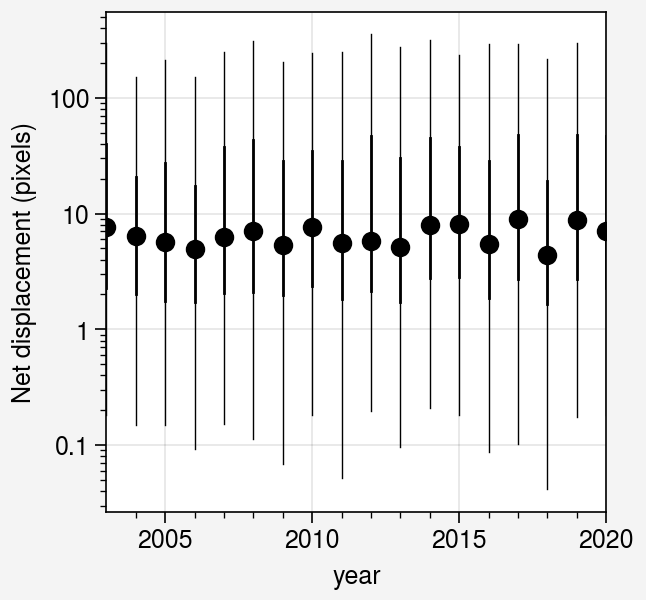

In [6]:
# Calculate the 1st percentile range for the median pixel path length for identified floes
fig, ax = pplt.subplots()
for year in ift_dfs:
    pls = ift_dfs[year].groupby('floe_id').apply(net_displacement_pixels)
    ax.plot([year, year], pls.quantile([0.01, 0.99]), lw=0.5, marker='', color='k')
    ax.plot([year, year], pls.quantile([0.25, 0.75]), lw=1, marker='', color='k')
    ax.plot([year], pls.quantile([0.5]), lw=0, marker='o', color='k')
ax.format(xlabel='year', ylabel='Net displacement (pixels)', yscale='log')

Similarly, we want to avoid physically impossible drift speeds. Sea ice rarely reaches even 1 m/s, particularly when averaged over the course of a day. Setting a maximum average drift speed to 1.5 m/s removes less than 1% of the observations from the pool of true positive floe shapes. Similarly, setting the minimum average drift speed to 0.01 m/s only removes a few floes.

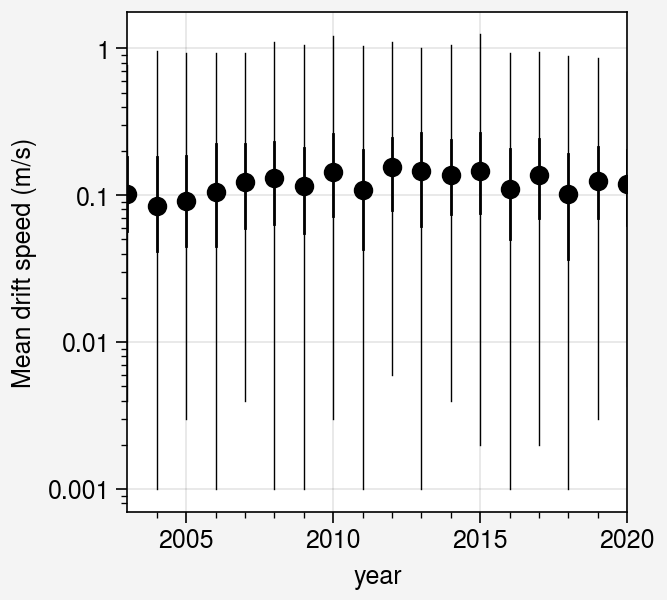

In [7]:
# Calculate the distribution of mean speeds for tracked floes
fig, ax = pplt.subplots()
for year in ift_dfs:
    mds = ift_dfs[year].groupby('floe_id').apply(estimated_mean_speed)
    ax.plot([year, year], mds.quantile([0.01, 0.99]), lw=0.5, marker='', color='k')
    ax.plot([year, year], mds.quantile([0.25, 0.75]), lw=1, marker='', color='k')
    ax.plot([year], mds.quantile([0.5]), lw=0, marker='o', color='k')
ax.format(xlabel='year', ylabel='Mean drift speed (m/s)', yscale='log')

# Classifying floes as true and false positives
This code block strings together the steps used for labeling each observations as a true positive (TP), false positive (FP), or unknown (UK). 

In [12]:
%%time
for year in range(2003, 2021):
    ift_df = ift_dfs[year].copy()
    
    # Drop too-small floes (really only for 2020 since the others already filtered)
    ift_df = ift_df.loc[ift_df.area >= 300].copy() 

    ift_df['circularity'] = 4*np.pi*ift_df['area']/ift_df['perimeter']**2 
    # Circularity really only goes from 0 to 1, however since there is some uncertainty
    # in perimeter calculations for discrete data I include a tolerance for higher values.
    ift_df = ift_df.loc[(ift_df.circularity > 0) & (ift_df.circularity < 1.2)].copy()

 
    # Scale the pixel brightness data to 0-1
    for var in ['tc_channel0', 'tc_channel1', 'tc_channel2', 'fc_channel0', 'fc_channel1', 'fc_channel2']:
        ift_df[var] = ift_df[var]/255
    
    # Select the tracked floes
    df_floes = ift_df.loc[ift_df.floe_id != 'unmatched']
    
    # Require a minimum of at least 1 pixel total displacement
    df_floes = df_floes.groupby('floe_id').filter(lambda x: net_displacement_pixels(x) > 1)
    
    # Average speed has to be less than 1.5 m/s and greater than 0.01 m/s
    df_floes = df_floes.groupby('floe_id').filter(lambda x: (estimated_mean_speed(x) < 1.5) & \
                (estimated_mean_speed(x) > 0.01))

    # Default classification is "Unknown"
    ift_df['classification'] = 'UK'
    
    # Remove SIC=0 and landmasked floes from TP dataset
    df_floes = df_floes.loc[(df_floes.nsidc_sic > 0) & (df_floes.nsidc_sic <= 1)]
    ift_df.loc[ift_df.nsidc_sic == 0, 'classification'] = 'FP'
    ift_df.loc[df_floes.index, 'classification'] = 'TP'
    
    ift_dfs[year] = ift_df.copy()

CPU times: user 49.3 s, sys: 437 ms, total: 49.7 s
Wall time: 49.6 s


# Adding false positives based on the relationship between length scale and sea ice concentration
The following figure shows the relationship between $L = 0.25 * \sqrt{A}$ (0.25 km / pixel) and sea ice concentration. We leverage this information to select a large set of false positives. The previously selected data has a pretty large set of cloud artifacts, which we want to remove, but lacks objects in sea ice filaments, which we also want to remove.

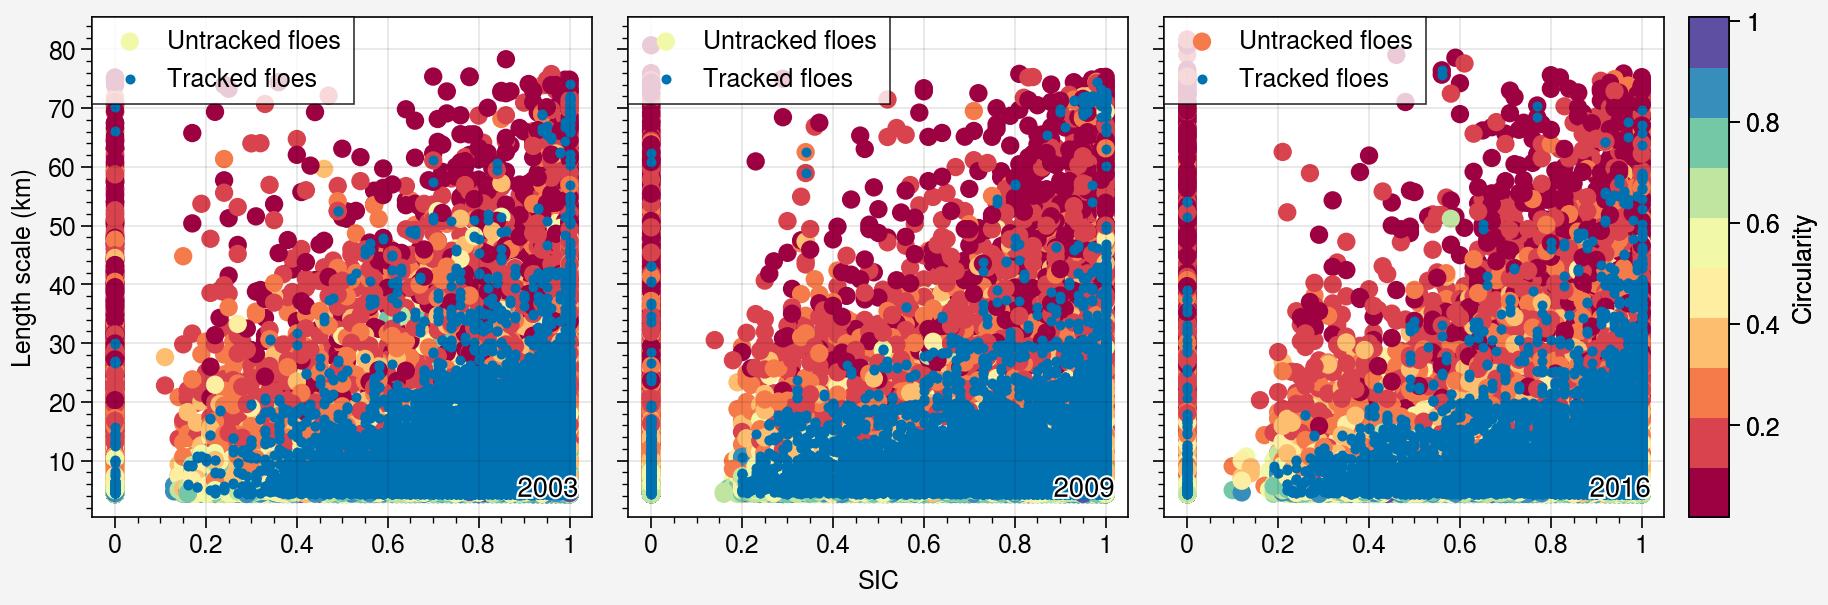

In [15]:
fig, axs = pplt.subplots(ncols=3)
for ax, year in zip(axs, [2003, 2009, 2016]):
    df = ift_dfs[year]
    df = df.loc[(df.nsidc_sic <= 1) & (df.area > 300)]
    c = ax.scatter(df.nsidc_sic.values, np.sqrt(df.area) * 0.25,
                   c=df.circularity, cmap='spectral', label='Untracked floes', N=10)
    
    ax.scatter(df.loc[df.floe_id != 'unmatched', 'nsidc_sic'].values,
               np.sqrt(df.loc[df.floe_id != 'unmatched', 'area'].values) * 0.25, marker='.', label='Tracked floes')
    ax.format(ylabel='Length scale (km)', xlabel='SIC', lrtitle=year)
    ax.legend(loc='ul', ncols=1)
fig.colorbar(c, loc='r', label='Circularity')    

We calculate the 99th percentile for the length scales binned by sea ice concentration to the nearest tenth. Then we fit a line to this value.

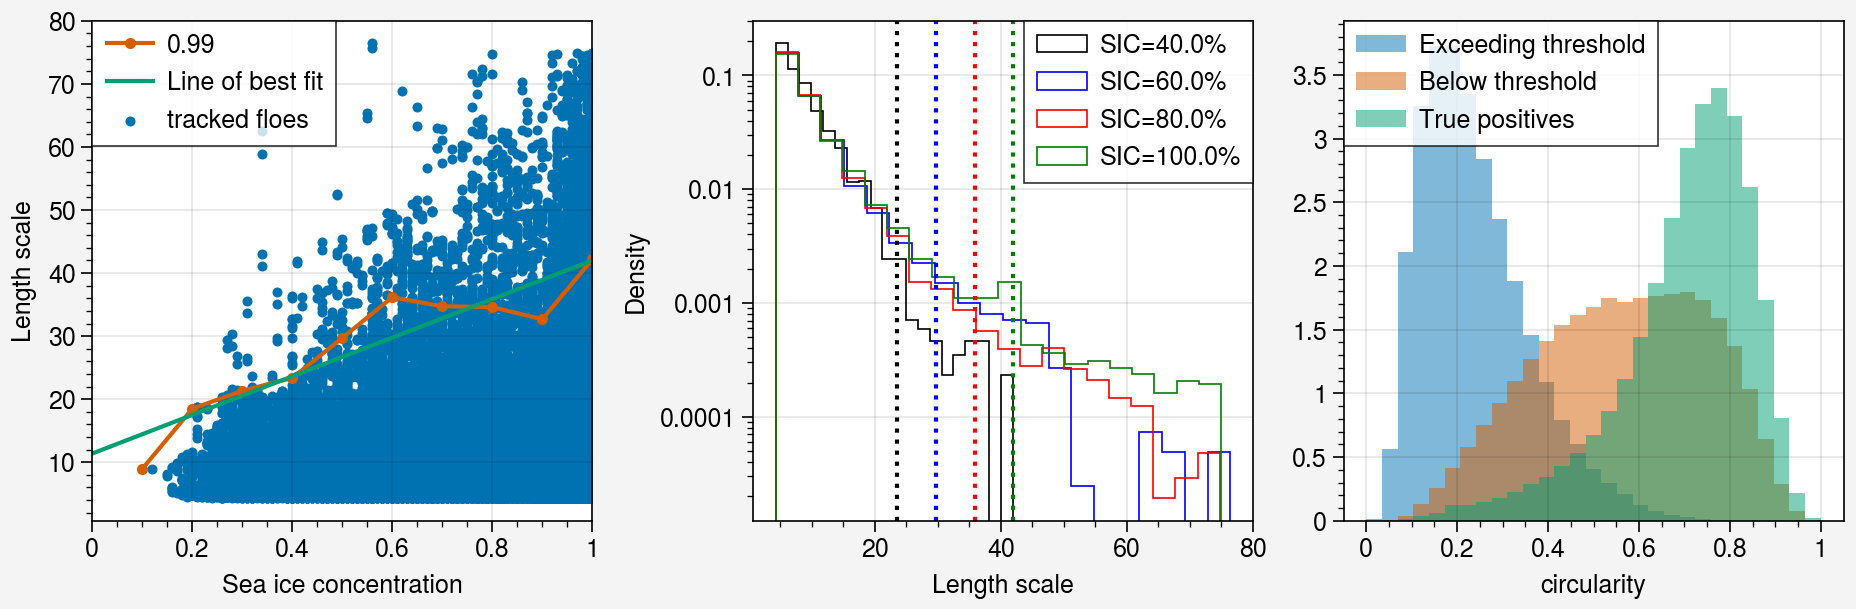

In [18]:
ift_all = pd.concat([ift_dfs[year] for year in ift_dfs])
all_tp_data = ift_all.loc[ift_all.classification == 'TP', :].copy()
all_tp_data['sic'] = np.round(all_tp_data.nsidc_sic, 1)
result = all_tp_data.loc[:, ['sic', 'area']].groupby('sic').quantile([0.99])
result.index.names = ['sic', 'quantile']
result = result.pivot_table(index='sic', columns='quantile', values='area')

# Define a threshold function based on the 99th percentile of length scale for tracked floes
params = linregress(result[0.99].index, np.sqrt(result[0.99].values)*0.25)
threshold = lambda x: params.slope * x + params.intercept

fig, ax = pplt.subplots(ncols=3, share=False)
ax[0].scatter(all_data['nsidc_sic'].values, np.sqrt(all_data['area'])*0.25, marker='.', label='tracked floes')
ax[0].plot(np.sqrt(result[0.99])*0.25, marker='.')
x = np.linspace(0, 1, 10)
ax[0].plot(x, threshold(x), label='Line of best fit')
ax[0].legend(ncols=1)
for sic, c in zip([0.4, 0.6, 0.8, 1.0], ['k', 'b', 'r', 'g']):
    L = np.sqrt(all_tp_data.loc[all_tp_data.sic == sic, 'area'])*0.25
  
    ax[1].hist(np.sqrt(all_tp_data.loc[all_tp_data.sic == sic, 'area'])*0.25, bins=20, alpha=1, color=c, 
               histtype='step', density=True, label='SIC=' + str(sic*100) + '%') 
    ax[1].axvline(threshold(sic), color=c, ls=':')
ax[1].format(yscale='log', xlabel='Length scale', ylabel='Density')
ax[0].format(ylabel='Length scale', xlabel='Sea ice concentration')
ax[1].legend(ncols=1, loc='ur')

# Plot data with non-zero and non-infinite circularity, and with sea ice present
df = ift_all.loc[(ift_all.circularity > 0) & (ift_all.nsidc_sic <= 1)]
df = df.loc[(df.circularity <= 1)]

df['L'] = np.sqrt(df['area'])*0.25 # length scale in kilometers
df['excess'] = df['L'] > threshold(df['nsidc_sic'])
ax[2].hist(df.loc[df.excess, 'circularity'], alpha=0.5, density=True, label='Exceeding threshold', bins=np.linspace(0, 1, 30))
ax[2].hist(df.loc[~df.excess, 'circularity'], alpha=0.5, density=True, label='Below threshold', bins=np.linspace(0, 1, 30))

# add comparison to the true positive data
ax[2].hist(all_data.loc[all_data.classification=='TP', 'circularity'], alpha=0.5, density=True, label='True positives', bins=np.linspace(0, 1, 30))
ax[2].legend(loc='ul', ncols=1)

Now we use this linear fit to select another set of false positives.

In [85]:
for year in ift_dfs:
    # length scale in kilometers
    L = np.sqrt(ift_dfs[year]['area'])*0.25
    sic = ift_dfs[year]['nsidc_sic']
    excess = L > threshold(sic)
    classification = ift_dfs[year]['classification']
    ift_dfs[year].loc[(((sic > 0.15) & (sic < 0.85)) & excess) & (classification != 'TP'), 'classification'] = 'FP'

# Using the circularity and solidity
Circularity and solidity are measures of the shape of the floe. The figures below show a few key things. First, there are numerous cases of values with very low solidity, mostly also with low circularity. The black dots are the unknown objects, while the spectral map shows the tracked floes colored by floe size. Smaller floes tend more circular, and the floes with low circularity still tend to have moderately high solidity. On the right, we see that the vast majority of true positive floes have both high circularity and high solidity. The red lines mark thresholds for selecting false positives.

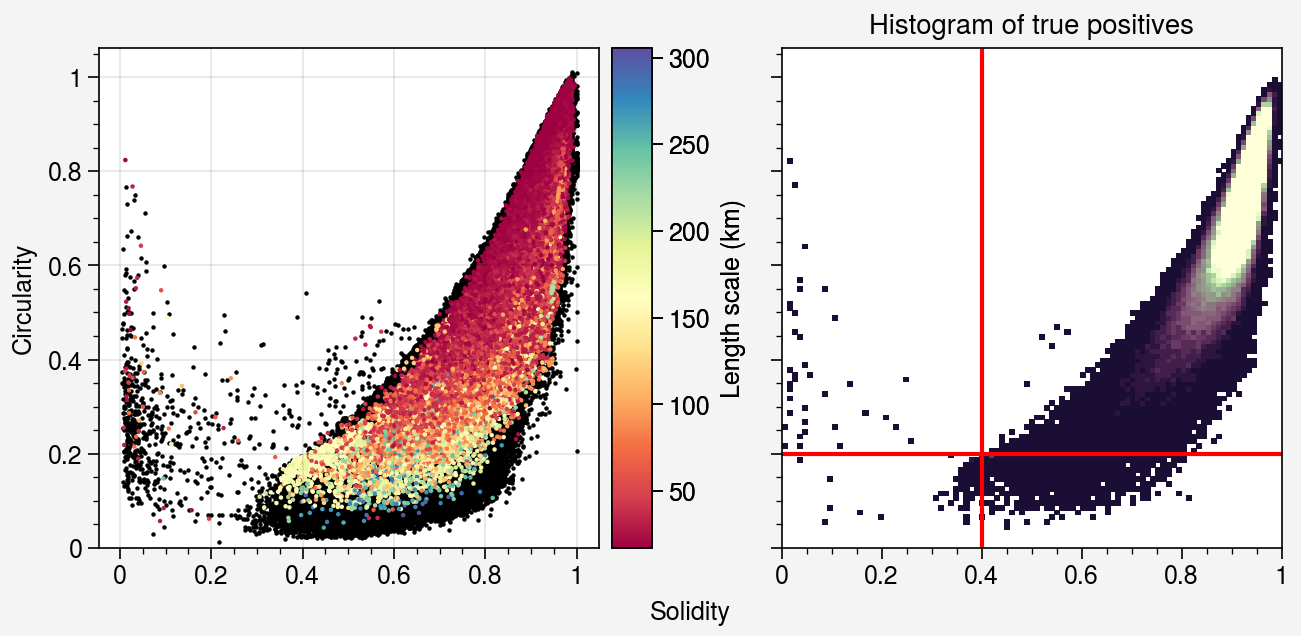

In [105]:
fig, ax = pplt.subplots(ncols=2)
df = ift_all.loc[ift_all.classification == 'UK']
ax[0].scatter(df.solidity.values, df.circularity.values, ms=1, color='k')

df = ift_all.loc[ift_all.classification == 'TP']
c = ax[0].scatter(df.solidity.values, df.circularity.values, c=np.sqrt(df.area), cmap='spectral', ms=1)
ax[0].colorbar(c, label='Length scale (km)')

xbins = np.linspace(0, 1, 100)
ybins = np.linspace(0, 1, 100)
h2d, xbins, ybins = np.histogram2d(all_tp_data['solidity'], all_tp_data['circularity'], bins=[xbins, ybins])
ax[1].pcolormesh(xbins, ybins, np.ma.masked_array(h2d.T, h2d.T == 0), N=20, vmin=10, vmax=300, extend='max', cmap='tokyo')
ax[1].axhline(0.2, color='r')
ax[1].axvline(0.4, color='r')
ax[1].format(title='Histogram of true positives')
ax.format(ylabel='Circularity', xlabel='Solidity')

In [106]:
for year in ift_dfs:
    # length scale in kilometers
    solidity = ift_dfs[year]['solidity']
    circularity = ift_dfs[year]['circularity']
    
    classification = ift_dfs[year]['classification']
    ift_dfs[year].loc[((circularity < 0.2) | (solidity < 0.4)) & (classification != 'TP'), 'classification'] = 'FP'

# Stratified random sample
We take a stratified random sample of up to 1000 data points from each month for each category. There are more false positives than true positives. For Apr-June, there are approximately the same number of true and false positives, decreasing thereafter. 

In [107]:
# Random seed
rs = 202408

#### Get random sample for training/testing
data_samples = []
for year in ift_dfs:
    for month, group in ift_dfs[year].groupby(ift_dfs[year].datetime.dt.month):
        if month != 3: # Only 1 day in March in any year, so we skip it. Only use full months.
            samples = group.loc[group.classification != 'UK'].groupby(
                    'classification').apply(lambda x: x.sample(min(len(x), 1000), replace=False, random_state=rs))
            if len(samples) > 0:
                data_samples.append(samples)
            else:
                print('No samples for', month, year)

data = pd.concat(data_samples).reset_index(drop=True)
print('Number of true and false positives for each month')
print(data[['area']].groupby([data.datetime.dt.month, data.classification]).count().pivot_table(
    index='datetime', values='area', columns='classification'))

Number of true and false positives for each month
classification       FP       TP
datetime                        
4               18000.0  16496.0
5               18000.0  17463.0
6               18000.0  17659.0
7               18000.0  11785.0
8               18000.0   6770.0
9               18000.0   3442.0


# Variables for logistic regression
We consider two measures of the floe shape (solidity and circularity) and the 6 channels of pixel color information. As it turns out, the shape measures are highly correlated. Circularity has been used in the literature for ice segmentation before, so we use it, though the results are unlikely to be different with solidity. The color channels are also highly correlated, which makes sense with snow/ice being white. The largest contrast is between the false color channel 0 and the other color channels. So we choose one true color channel and false color channel 0.

In [108]:
data['circularity'] = 4*np.pi*data['area']/data['perimeter']**2
variables = ['solidity', 'circularity', 'tc_channel0', 'tc_channel1', 'tc_channel2', 'fc_channel0', 'fc_channel1', 'fc_channel2']
data.loc[:, variables].corr().round(3)

,solidity,circularity,tc_channel0,tc_channel1,tc_channel2,fc_channel0,fc_channel1,fc_channel2
solidity,1.000,0.919,0.189,0.199,0.199,-0.248,0.156,0.181
circularity,0.919,1.000,0.201,0.212,0.211,-0.255,0.165,0.192
tc_channel0,0.189,0.201,1.000,0.999,0.997,0.271,0.989,0.994
tc_channel1,0.199,0.212,0.999,1.000,0.998,0.249,0.984,0.993
tc_channel2,0.199,0.211,0.997,0.998,1.000,0.243,0.980,0.989
fc_channel0,-0.248,-0.255,0.271,0.249,0.243,1.000,0.351,0.298
fc_channel1,0.156,0.165,0.989,0.984,0.980,0.351,1.000,0.995
fc_channel2,0.181,0.192,0.994,0.993,0.989,0.298,0.995,1.000


Falsecolor channels 1+2 are strongly correlated (>0.99) to each other and to both truecolor channels.
While there is potential to make a variable that removes the co-variability to an extent by taking a difference of channels, we initially focus on three variables: circularity, truecolor channel 0, and falsecolor channel 0. 

In [109]:
#### Train logistic regression model
from skimage.measure import regionprops_table
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

minimal_variables = ['circularity', 'tc_channel0', 'fc_channel0']
data = data.dropna(subset=minimal_variables)
# This are the variables that are not closely correlated with each other. Functions of other brightness channels could be useful.

X = data.loc[:, minimal_variables].to_numpy()
y =  (data.classification == 'TP').to_numpy()

# Split data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=1/3, random_state=10)

# Fit the logistic regression model using cross validation
lr_model = LogisticRegressionCV(Cs=10,
                     solver='lbfgs',
                     scoring='accuracy',
                     penalty='l2',
                     cv=10,
                     random_state=rs).fit(X_train, y_train)

#### Compute and print skill scores for the model
y_pred = lr_model.predict(X_test)
print('F1 score: ', np.round(f1_score(y_test, y_pred), 3))
print('Recall: ', np.round(recall_score(y_test, y_pred), 3))
print('Precision: ', np.round(precision_score(y_test, y_pred), 3))
print('Confusion matrix:')
print(pd.DataFrame(data=np.round(confusion_matrix(y_test, y_pred)/len(y_test), 2),
             index=['True', 'False'], columns=['PredTrue', 'PredFalse']))

F1 score:  0.878
Recall:  0.846
Precision:  0.912
Confusion matrix:
       PredTrue  PredFalse
True       0.56       0.03
False      0.06       0.34
